<a href="https://colab.research.google.com/github/orhbulu/repo/blob/master/ACV_Quickdraw_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickdraw

load data  - https://quickdraw.withgoogle.com/data
preprocessing data  
pipeline  
make a model  
train   
evaluate   


## Prepare data for network

In [0]:
!nvidia-smi

Wed Apr 15 23:11:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!wget -qq https://www.dropbox.com/s/gdlb8dnjzcly51o/quickdraw.zip
  
!unzip -qq quickdraw.zip

!rm -r __MACOSX
!rm quickdraw.zip

!ls

quickdraw  sample_data


In [0]:
!ls quickdraw

'alarm clock.npy'   bee.npy		 cookie.npy	  lollipop.npy
 ambulance.npy	   'birthday cake.npy'	 donut.npy	 'palm tree.npy'
 angel.npy	    brain.npy		 eyeglasses.npy   pig.npy
 ant.npy	    cactus.npy		 face.npy	  postcard.npy
 banana.npy	    cat.npy		 fish.npy	  rainbow.npy


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np

from glob import glob
import ntpath

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, Add, MaxPool2D, GlobalAvgPool2D
from tensorflow.keras.layers import Concatenate, AvgPool2D, Dropout, Flatten
from tensorflow.keras.models import Model

## Data Pipeline

In [0]:
file_names = glob('./quickdraw/*.npy')

In [0]:
class_names = []

for file in file_names:
  name = ntpath.basename(file)
  class_names.append(name[:-4])

In [0]:
x_data =np.array([])
y_labels =np.array([])

for i, filename in enumerate(file_names):
  labels = [i for j in range(50000)]
  arr = np.load(filename)
  arr = arr[:50000]
  if len(x_data) == 0:
    x_data = arr
    y_labels = np.asarray(labels)
  else:
    x_data = np.concatenate((x_data, arr))
    y_labels = np.concatenate((y_labels, labels))

In [0]:
n_classes = len(class_names)

# Convert Class Scalars to binary One Hot Encoded vectors
y_labels = tf.keras.utils.to_categorical(y_labels, n_classes)

In [0]:
y_labels.shape

(1000000, 20)

In [0]:
x_data.shape

(1000000, 784)

In [0]:
x_data_reshaped = np.array(x_data).reshape((1000000, 28, 28, 1))

In [0]:
x_data_reshaped.shape

(1000000, 28, 28, 1)

In [0]:
#Normalize the data
x_data_reshaped = np.divide(x_data_reshaped,255)

In [0]:
# Shuffle
from sklearn.utils import shuffle

x_data_reshaped, y_labels = shuffle(x_data_reshaped, y_labels, random_state=40)


# Train test split
from sklearn.model_selection import train_test_split

split = 0.9

x_train, x_test, y_train, y_test = train_test_split(x_data_reshaped, y_labels, test_size=0.1, random_state=42)


x_train.shape, y_train.shape

((900000, 28, 28, 1), (900000, 20))

## Model

Inception Cell Duplicate

In [0]:
def inception_cell(x, filters, block_name):
    # this is the. left most path with 1x1 convs
    branch1x1 = Conv2D(filters=filters[0], kernel_size=1, activation='relu',name=block_name+'_branch_1x1')(x)

    # this is the 3x3 path
    branch3x3 = Conv2D(filters=filters[1], kernel_size=1, activation='relu',name=block_name+'_3x3_branch_1x1')(x)
    branch3x3 = Conv2D(filters=filters[2], kernel_size=3, padding='same', activation='relu',name=block_name+'_3x3_branch_3x3')(branch3x3)

    # this is the 5x5 path
    branch5x5 = Conv2D(filters=filters[3], kernel_size=1, activation='relu',name=block_name+'_5x5_branch_1x1')(x)
    branch5x5 = Conv2D(filters=filters[4], kernel_size=5, padding='same', activation='relu',name=block_name+'_5x5_branch_5x5')(branch5x5)

    # this is the pooling branch
    pooling_branch = MaxPool2D(pool_size=3, strides=1, padding='same',name=block_name+'_pooling_branch_')(x)
    pooling_branch = Conv2D(filters=filters[5], kernel_size=1, activation='relu',name=block_name+'_pooling_branch_1x1')(pooling_branch)

    # the filters get concatenated
    output = Concatenate()([branch1x1, branch3x3, branch5x5, pooling_branch])
    return output

#  Inception Cell Model 

In [0]:
input = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=7, strides=1, padding='same', activation='relu',name='1a')(input)
x = MaxPool2D(pool_size=3, strides=1, padding='same',name='1-pooling')(x)
x = BatchNormalization()(x)

x = inception_cell(x, filters=[64, 96, 128, 16, 32, 32],block_name='3a')
x = inception_cell(x, filters=[128, 128, 192, 32, 96, 64],block_name='3b')
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)

# x = inception_cell(x, filters=[192, 96, 208, 16, 48, 64],block_name='4a')
# x = inception_cell(x, filters=[160, 112, 224, 24, 64, 64],block_name='4b')
# x = inception_cell(x, filters=[128, 128, 256, 24, 64, 64],block_name='4c')
# x = inception_cell(x, filters=[112, 144, 288, 32, 64, 64],block_name='4d')
# x = inception_cell(x, filters=[256, 160, 320, 32, 128, 128],block_name='4e')
# x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
# x = BatchNormalization()(x)


x = inception_cell(x, filters=[256, 160, 320, 32, 128, 128],block_name='5a')
x = inception_cell(x, filters=[384, 192, 384, 48, 128, 128],block_name='5b')
x = AvgPool2D(pool_size=7, strides=1,name='AvePooling')(x)
x = Dropout(rate=0.4,name='Dropout')(x)

x = Flatten()(x)
output = Dense(units=20, activation='softmax')(x)

model = Model(inputs=input, outputs=output,name='GoogLeNet-InceptionV1')

In [0]:
model.summary()

Model: "GoogLeNet-InceptionV1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
1a (Conv2D)                     (None, 28, 28, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
1-pooling (MaxPooling2D)        (None, 28, 28, 64)   0           1a[0][0]                         
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         1-pooling[0][0]                  
______________________________________________________________________________

## Train

In [0]:
batch_size = 128
epochs = 5
learning_rate = 0.001

In [0]:
#optimizer
opt = tf.keras.optimizers.Adam(lr = learning_rate)

model.compile(loss= tf.keras.losses.categorical_crossentropy,
              optimizer= opt,
              metrics=['accuracy'])

In [0]:
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks = None,
          validation_data=(x_test, y_test))

Epoch 1/5
7032/7032 [==============================] - 933s 133ms/step - loss: 0.3515 - accuracy: 0.9030 - val_loss: 0.2392 - val_accuracy: 0.9342
Epoch 2/5
7032/7032 [==============================] - 930s 132ms/step - loss: 0.2210 - accuracy: 0.9393 - val_loss: 0.2057 - val_accuracy: 0.9437
Epoch 3/5
7032/7032 [==============================] - 927s 132ms/step - loss: 0.1967 - accuracy: 0.9460 - val_loss: 0.1949 - val_accuracy: 0.9472
Epoch 4/5
7032/7032 [==============================] - 926s 132ms/step - loss: 0.1801 - accuracy: 0.9501 - val_loss: 0.1904 - val_accuracy: 0.9477
Epoch 5/5
7032/7032 [==============================] - 931s 132ms/step - loss: 0.1680 - accuracy: 0.9533 - val_loss: 0.1907 - val_accuracy: 0.9489


## Evaluate 

In [0]:
def plot_train(hist):
    h = hist.history
    if 'accuracy' in h:
        meas='accuracy'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

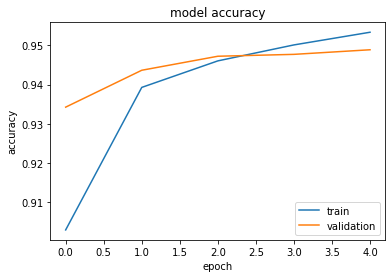

In [0]:
plot_train(hist)

In [0]:
model.evaluate(x=x_test, y=y_test)

3125/3125 [==============================] - 39s 12ms/step - loss: 0.1908 - accuracy: 0.9489


[0.19079403579235077, 0.9488700032234192]

In [0]:
print(model.metrics_names)

['loss', 'accuracy']
